In [11]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import random
from scipy.integrate import solve_ivp

def construct_intermediate_hamiltonian(H0,Hf,s):
    return H0 * (1-s) + Hf * s

# Time-dependent Schrödinger equation with normalization
def normalized_tdse(t, psi, H0, Hf, t_total, interpolation_type = "sine-squared"):
    psi = psi / np.linalg.norm(psi)  # Normalize the wavefunction
    if interpolation_type == "sine-squared":
        s = np.sin((np.pi/2) * (t / t_total))**2  # sine^2 interpolation
    elif interpolation_type == "linear":
        s = t/t_total # linear interpolation
    elif interpolation_type == "smoothstep":
        s = 3(t/t_total)^2 - 2(t/t_total)^3 
    else: 
        print(f"The {interpolation_type} interpolation method is not added yet. ")
        pass
        
    H_s = construct_intermediate_hamiltonian(H0, Hf, s)
    return -1j * H_s.dot(psi)

# Function to evolve the system
def evolve_system(H0, Hf, psi0, t_total, t_points):
    t_eval = np.linspace(0, t_total, t_points)
    sol = solve_ivp(
        normalized_tdse, [0, t_total], psi0, t_eval=t_eval, 
        args=(H0, Hf, t_total, interpolation_type = "smoothstep"), method="RK45",
        rtol=1e-10, atol=1e-12
    )
    return sol.t, sol.y

# Function to calculate the instantaneous energy
def instantaneous_energy(H, psi):
    return np.real(np.vdot(psi, H @ psi))

<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Joe\AppData\Local\Temp\ipykernel_30468\2038580233.py:32: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(t/t_total, ground_state_prob, "-b", label = "$\psi_{0}^{T} \psi_0$")


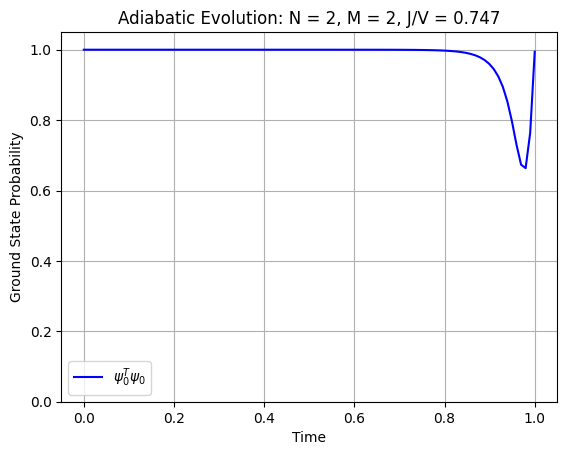

In [14]:
N = 2
M = 2
mu = 100

V = 1
J_V_ratio = random.uniform(0.1,1)
J = J_V_ratio * V

t_total = 1000  # Increase to make evolution slower
t_points = 100 # Higher resolution for better accuracy

H0 = construct_initial_hamiltonian(N, M, mu)
Hf = construct_hamiltonian(N, M, J, V)

eigvals, eigvecs = np.linalg.eigh(H0)
psi0 = eigvecs[:, 0]
psi0 = psi0 / np.linalg.norm(psi0)  # Ensure normalization

# Evolve the system
t, psi_t = evolve_system(H0, Hf, psi0, t_total, t_points)

# Calculate ground state probabilities
ground_state_prob = np.zeros_like(t)
for i in range(len(t)):
    s = np.sin((np.pi/2) * (t[i] / t_total))**2
    H_s = construct_intermediate_hamiltonian(H0, Hf, s)
    _, eigvecs_s = exact_diagonalize(H_s)
    psi_ground_state_s = eigvecs_s[0]  # Ground state at time t
    ground_state_prob[i] = np.abs(np.dot(np.conjugate(psi_ground_state_s), psi_t[:, i]))**2

fig, ax = plt.subplots()
ax.plot(t/t_total, ground_state_prob, "-b", label = "$\psi_{0}^{T} \psi$")

ax.set_xlabel("Time")
ax.set_ylabel("Ground State Probability")
ax.set_title(f"Adiabatic Evolution: N = {N}, M = {M}, J/V = {round(J_V_ratio,3)}")
ax.set_ylim(0,1.05)
ax.grid()
ax.legend()



<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Joe\AppData\Local\Temp\ipykernel_30468\1956078497.py:29: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(t/t_total, energies, ".r", label="$H\psi(t)$")
C:\Users\Joe\AppData\Local\Temp\ipykernel_30468\1956078497.py:43: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(t/t_total, true_ground_state_energies / energies, ".k", label="$E_0 / H\psi(t)$")
C:\Users\Joe\AppData\Local\Temp\ipykernel_30468\1956078497.py:48: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(t/t_total, excited_state_energies[j] / energies, ".", color = color, label=f"$E_{j+1} / H\psi(t)$")
C:\

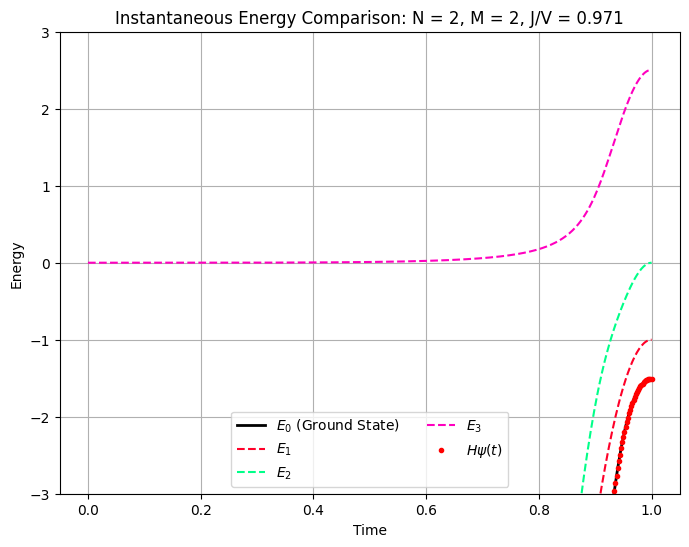

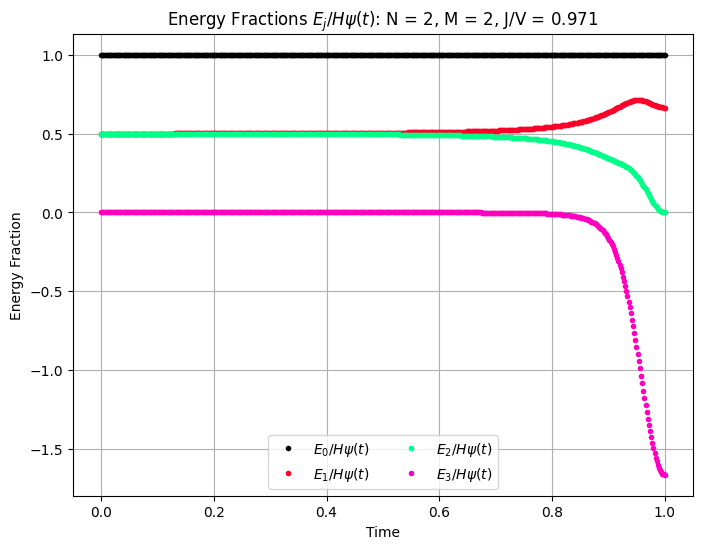

In [ ]:
n_excited_states = 3
cmap = get_cmap("gist_rainbow", n_excited_states)

energies = np.zeros(len(t))
true_ground_state_energies = np.zeros(len(t))
excited_state_energies = np.zeros((n_excited_states, len(t)))

for i in range(len(t)):
    s = np.sin((np.pi/2) * (t[i] / t_total))**2
    H_s = construct_intermediate_hamiltonian(H0, Hf, s)
    
    energies[i] = instantaneous_energy(H_s, psi_t[:, i])
    
    eigvals_s, _ = exact_diagonalize(H_s)
    
    true_ground_state_energies[i] = eigvals_s[0]
    
    for j in range(n_excited_states):
        excited_state_energies[j, i] = eigvals_s[j + 1]  # +1 to skip the ground state

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(t/t_total, true_ground_state_energies, "-k", linewidth=2, label="$E_0$ (Ground State)")

for j in range(n_excited_states):
    color = cmap(j)
    ax.plot(t/t_total, excited_state_energies[j], linestyle='--', color = color, label=f"$E_{j+1}$")

ax.plot(t/t_total, energies, ".r", label="$H\psi(t)$")

ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.set_title(f"Instantaneous Energy Comparison: N = {N}, M = {M}, J/V = {round(J_V_ratio,3)}")
ax.legend(ncols = (n_excited_states+2)//2, loc = "lower center")
ax.set_ylim(-3,3)

ax.grid()

# Plot the ratio of energies
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ratio of ground state energy to instantaneous energy
ax.plot(t/t_total, true_ground_state_energies / energies, ".k", label="$E_0 / H\psi(t)$")

# Plot the ratio of each excited state energy to instantaneous energy
for j in range(n_excited_states):
    color = cmap(j)
    ax.plot(t/t_total, excited_state_energies[j] / energies, ".", color = color, label=f"$E_{j+1} / H\psi(t)$")

ax.set_xlabel("Time")
ax.set_ylabel("Energy Fraction")
ax.set_title(f"Energy Fractions $E_j / H\psi(t)$: N = {N}, M = {M}, J/V = {round(J_V_ratio,3)}")
ax.legend(ncols = (n_excited_states+1)//2, loc = "lower center")
ax.grid()

plt.show()

